# Forecast Machile Learning Model with LSTM (long short-term memory)

In [22]:
import pandas as pd

file_path = 'NVDA.csv'

df = pd.read_csv(file_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376358,271468800
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000


In [23]:
# selecionando as colunas

df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1999-01-22,0.410156
1,1999-01-25,0.453125
2,1999-01-26,0.417969
3,1999-01-27,0.416667
4,1999-01-28,0.415365


In [24]:
# transformanda os dados de Date para o tipo data

import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

# exemplo
datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [25]:
# aplicando a função de conversão de tipo de data a coluna Date

df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

0   1999-01-22
1   1999-01-25
2   1999-01-26
3   1999-01-27
4   1999-01-28
Name: Date, dtype: datetime64[ns]

In [26]:
df.index = df.pop('Date')
df.head()

,Close
Date,
1999-01-22,0.410156
1999-01-25,0.453125
1999-01-26,0.417969
1999-01-27,0.416667
1999-01-28,0.415365


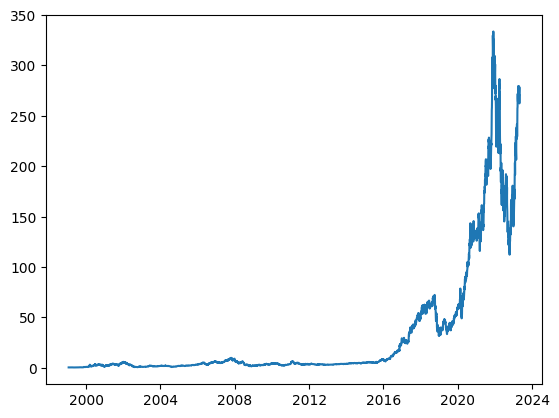

In [27]:
# visualizando os dados

import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [39]:
# transforma o dataframe em um dataframe com "janela"

import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date = str_to_datetime(last_date_str)

  target_date = first_date

  dates, X, Y = [], [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                # '1999-03-25',
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df.head()

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,131.862503,130.707504,126.430000,125.352501
1,2021-03-26,130.707504,126.430000,125.352501,128.392502
2,2021-03-29,126.430000,125.352501,128.392502,129.482498
3,2021-03-30,125.352501,128.392502,129.482498,128.717499
4,2021-03-31,128.392502,129.482498,128.717499,133.482498


In [40]:
# transforma o dado para ser utilizado pelo modelo de machine learning

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy() # converte para numpy array

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

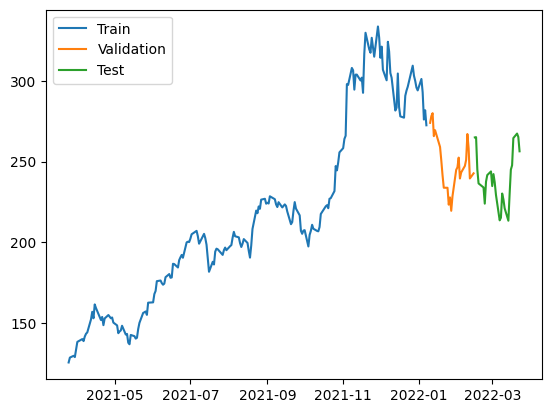

In [41]:
# dadps de treino, validação e teste 

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [42]:
# criando e treinando o modelo

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# definindo o modelo
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 98ms/step - loss: 48942.9062 - mean_absolute_error: 214.0840 - val_loss: 61850.5664 - val_mean_absolute_error: 248.1438
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 48723.9453 - mean_absolute_error: 213.5664 - val_loss: 61637.5547 - val_mean_absolute_error: 247.7143
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 48520.3672 - mean_absolute_error: 213.0928 - val_loss: 61338.6094 - val_mean_absolute_error: 247.1103
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 48246.4336 - mean_absolute_error: 212.4506 - val_loss: 61003.5898 - val_mean_absolute_error: 246.4312
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 47931.1953 - mean_absolute_error: 211.6966 - val_loss: 60585.5938 - val_mean_absolute_error: 245.5809
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 47475.5586 - mean_absolute_error: 210.6157 - val_loss: 59881.2

7/7 [==============================] - 1s 4ms/step


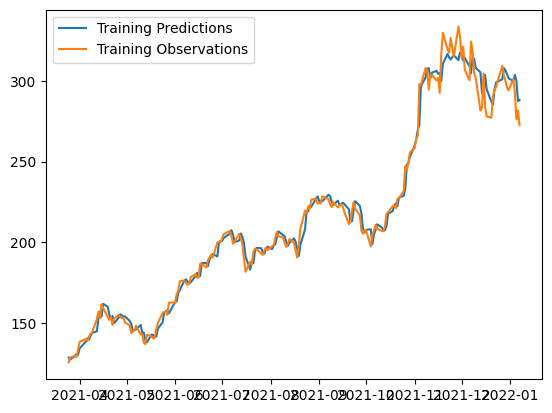

In [43]:
# visualização dos dados treinados

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 22ms/step


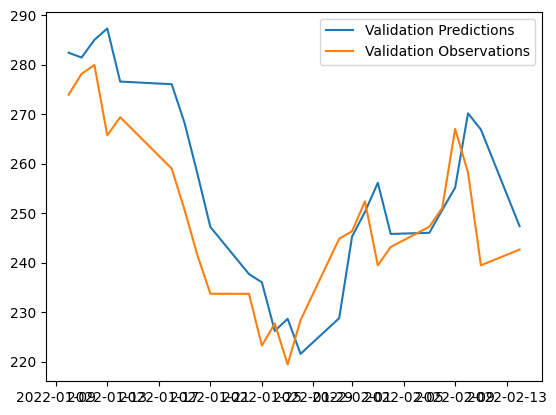

In [44]:
# visualizando os dados treinados

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 24ms/step


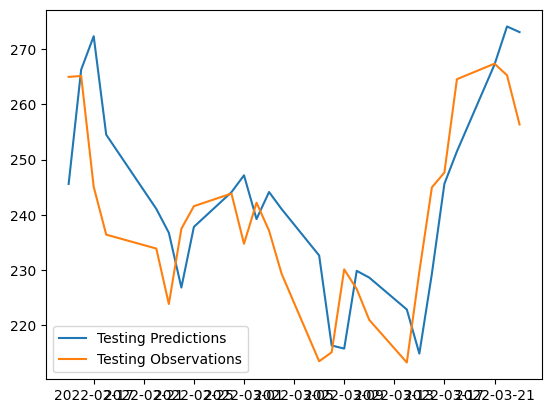

In [45]:
# visualizando os dados de teste

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

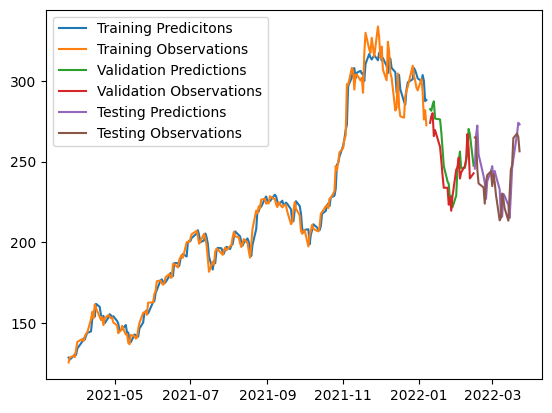

In [46]:
# visualização geral

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val , y_val)
plt.plot(dates_test , test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predicitons',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [48]:
# predição recursiva

from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 32ms/step


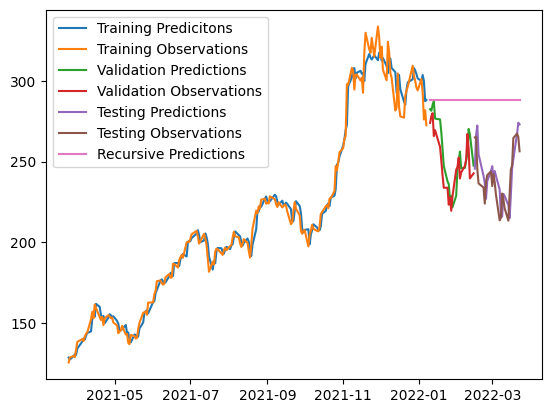

In [50]:
# visualização geral

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val , y_val)
plt.plot(dates_test , test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predicitons',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])